In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f


spark = (
    SparkSession.builder.appName("ModelTraining")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)


In [2]:
TRAININGDATA="training.1600000.processed.noemoticon.csv"
TESTINGDATA="testdata.manual.2009.06.14.csv"

In [3]:
# !wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

In [4]:
# !unzip trainingandtestdata.zip

In [17]:
schema = "polarity FLOAT, id INT, date_time STRING, query STRING, user STRING, tweets STRING"
raw_training_data = spark.read.csv(
    TRAININGDATA, schema=schema
).cache()

In [18]:
#raw_train_df = raw_training_data.toPandas()

# Natural Language Processing

We are going to use Stop Words, Lemmatization, Stemming and special characters replacement to clean our data.

In [60]:
import re
import string
from stop_words import ENGLISH_STOP_WORDS
def cleaner(x, stemming):
    text = str(x).lower()
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', text)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•"«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    tweet = re.sub(r"can'?t", ' can not', s)
    tweet = re.sub(r"n't", ' not', tweet)
    tweet = re.sub(r"'s", ' is', tweet)
    tweet = re.sub(r"i'm", ' i am ', tweet)
    tweet = re.sub(r"'ll", ' will', tweet)
    tweet = re.sub(r"'ve", ' have', tweet)
    tweet = re.sub(r"'d", ' would', tweet)
    tweet = re.sub(r'\&amp;|\&gt;|&lt;|\&', ' and ', tweet)
    url = re.compile(r'(https?[^\s]*)')
    smile = re.compile(r'[8:=;][\'`\-]?[\)d]+|[)d]+[\'`\-][8:=;]')
    sad = re.compile(r'[8:=;][\'`\-]?\(+|\)+[\'`\-][8:=;]')
    lol = re.compile(r'[8:=;][\'`\-]?p+')
    tweet = re.sub(r'\@[^\s]+', ' U ', tweet)
    tweet = url.sub(' ', tweet)
    tweet = re.sub(r'\/', ' ', tweet)
    tweet = smile.sub(' H ', tweet)
    tweet = lol.sub(' H ', tweet)
    tweet = sad.sub(' S ', tweet)
    tweet = re.sub(r'([\!\?\.]){2,}', '\g<1>', tweet)
    tweet = re.sub(r'\b(\S*?)([^\s])\2{2,}\b', '\g<1>\g<2>', tweet)
    tweet = re.sub(r'\#', ' #', tweet)
    tweet = re.sub(r'[^\w\#\s\?\<\>]+', ' ', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    text = re.sub('\[.*?\]', '', tweet)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    chain = ''
    if stemming == 'lemmatize':
        chain = ' '.join([Word(word).lemmatize() for word in text.split(' ') if word not in ENGLISH_STOP_WORDS])
    elif stemming == 'stemming':
        chain = ' '.join([Word(word).stem() for word in text.split(' ') if word not in ENGLISH_STOP_WORDS])
    else:
        chain = ' '.join([word for word in text.split(' ')])
    return chain

In [61]:
clean_train_data = raw_training_data.withColumn('tweets', f.udf(lambda x:cleaner(x, 'nature'))("tweets"))

# Make a word cloud

Polarity is like 0 for negatives, 2 for neutrals and 4 for positives tweets. 

Now let’s take a look of most frequent word in a word cloud.

In [62]:
wordcloud_data = clean_train_data.filter(f.col("polarity") < 2.0)

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [65]:
def word_cloud(tweets, kind, sense):
    corpus = []
    for it, row in tweets.items():
        corpus.append(str(row))
    corpus = ' '.join([word for word in corpus])
    # Generate a word cloud image
    mask = np.array(Image.open("twitter_logo.jpg"))
    wordcloud_nature = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(corpus)

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[18, 18])
    plt.imshow(wordcloud_nature.recolor(color_func=image_colors))
    plt.axis("off")

    # store to file
    #plt.savefig("wc_" + kind + "_" + sense + ".png", format="png")
    
    # plot it
    plt.show()

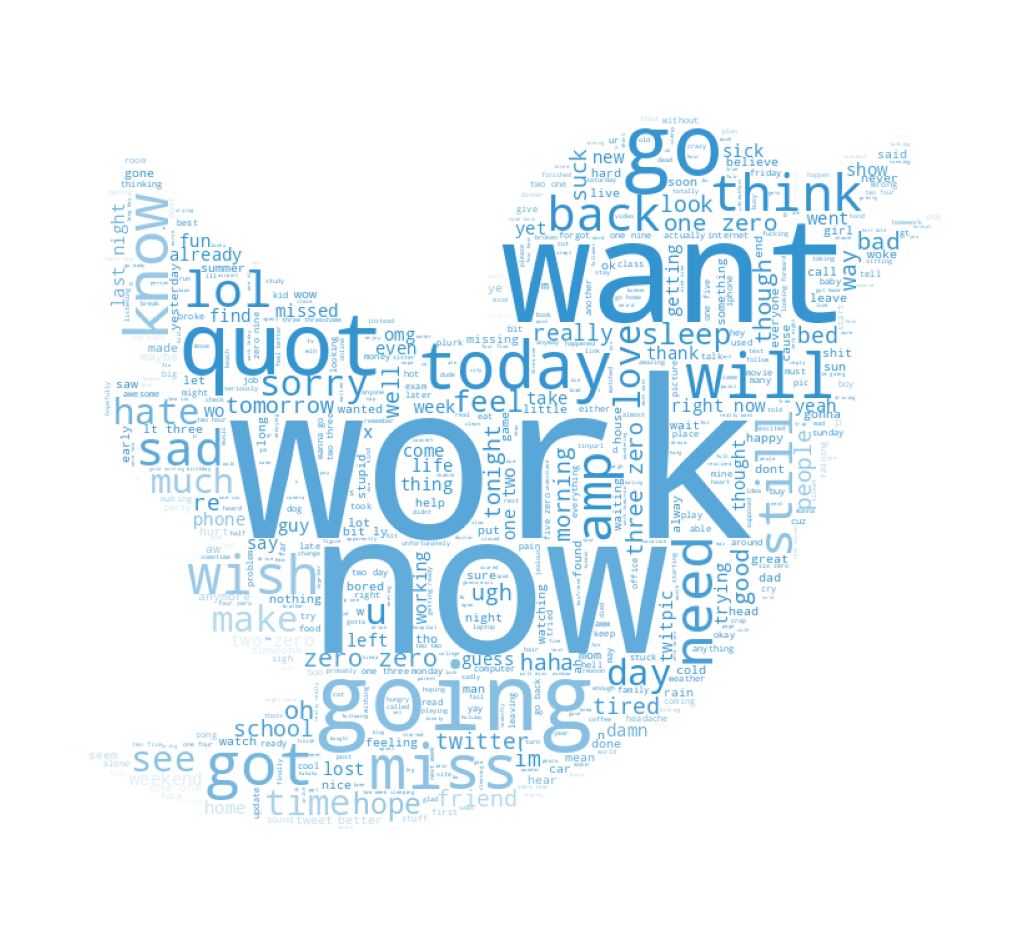

In [66]:
word_cloud(wordcloud_data.toPandas()['tweets'], 'natural', 'negative')

In [ ]:
#spark.stop()